# Hashin's Variational Model 

Notebook made by Kristine M. Jespersen

XX intro explaining that it is a model that estimates the stiffness degradation for cross-ply composites caused by transverse cracking.

First, we import the relevant packages:

In [1]:
import numpy as np
import math as m
import matplotlib.pyplot as plt
%matplotlib inline 

For easy repeated use of the model we wish to implement, it is useful to create it as a function. When doing so, it is necessary to first think about which input and output parameters we wish the function to have. In the case of Hashin's model, the main input parameters will be the material properties: $E_a$, $E_t$, $G_t$ and $\nu_a$ and the layer thicknesses $t_1$ and $t_2$. Additional parameters can be added to one's liking, and in this case we choose to also add a maximum value for the crack density, c, and a toggle for normalisation of the stiffness. 

This leads to the following function definition, where cMax and normToggle are optional input parameters with a default value of 1.

In [5]:
def hashin1985(Ea, Et, Ga, Gt, va, vt, t1, t2, cMax=1, normToggle=1):
    """
    This code was written by Kristine Munk Jespersen (kmun@dtu.dk)
    
    Parameters
    ----------
    Ea : float
        Young's modulus in fibre direction (load dir, 0 deg ply)
    Et : float
        Young's modulus in transverse direction (load dir, 90 deg ply)
    Ga : float
        Axial shear modulus (load dir, 0 deg ply)
    Gt : float
        Transverse shear modulus (load dir, 90 deg ply)
    va : float
        associated axial Poisson's ratio (load dir, 0 deg ply)
    vt : float
        associated transverse Poisson's ratio (load dir, 90 deg ply)
    t1 : float
        thickness of 90 deg layer(s).
    t2 : float
        thickness of 0 deg layer (s).
    cMax : float (default value = 1)
        Max value for the crack density 
    normToggle : int (default value = 1)
        Output normalized stiffness (=1), or absoulute stiffness (=0)
    Returns
    -------
    Ex : ndarray, shape (N)
        Stiffness degradation as a function of crack density array
    c : ndarray, shape (N)
        Crack density array following the Ex array.
    ExMin : float
        Stiffness at crack saturation (lower bound value)
    
    References
    ----------
    .. [1] Z. Hashin, Analysis of cracked laminates: a variational approach,
           Mechanics of materials 4 (1985) 121-136   
    """
    
    #Other parameters (Not to be modified)
    h=t1+t2
    lambda1=t2/t1
    E_0=t2/h*Ea+t1/h*Et
    print('t2='+str(t2)+', t1='+str(t1)+', h='+str(h)+', Ea='+str(E_a)+', Et='+str(E_t)+'--> E0='+str(E_0))  
    k1=Et/E_0
    c=np.linspace(0,cMax,100)    
    
    # Constants and other parameters from Hashin
    C00=1/Et+1/(lambda1*Ea)
    C02=(vt/Et)*(lambda1+2./3.)-(va*lambda1/(3.*Ea))
    C22=(lambda1+1)*(3*lambda1**2.+12.*lambda1+8.)/(60.*Et)
    C11=1./3.*(1/Gt+lambda1/Ga)
    q=C00/C22
    p=(C02-C11)/C22
    theta = m.atan(np.sqrt(4*q/(p**2.)-1.))
    alpha=q**(1./4.)*np.cos(1/2.*theta);
    beta=q**(1./4.)*np.sin(1/2.*theta);
        
    #print('E0='+str(E_0)+', q='+str(q)+', p='+str(p))        
    
    # Limiting value for the stiffness degradation (Hashin)
    C_lim=1./E_0+k1**2./(lambda1+1.)*(1/Et+1./(lambda1*Ea))
    Elim=1./C_lim
    
    # Stiffness as function of the crack density assuming equal space between cracks and no interaction 
    rho=1/(2*c*t1)
    eta = (3.*lambda1**2.+12.*lambda1+8.)/60.
    chi=2*alpha*beta*(alpha**2+beta**2)*(np.cosh(2.*alpha*rho)-np.cos(2*beta*rho))/(alpha*np.sin(2*beta*rho)+beta*np.sinh(2*alpha*rho))
    chi[np.isnan(chi)] = 0
    compl=1/E_0+1/Et*k1**2*eta*chi/rho
    Ex=1/compl
       
    
    if normToggle==1:
        return Ex/E_0, c, Elim/E_0
    else:
        return Ex, c, Elim

Now let's try to use the function using the same parameters as in Hashin 1985 (note that the warnings below are caused for a crack density of zero and can be ignored):

In [3]:
t2=0.203
t1=3*t2
E_a=41.7
nu_a=0.30
E_t=13.
nu_t=0.42
G_a=3.4
G_t=4.580
cMax=1     

ExNorm,c,ElimNorm = hashin1985(E_a, E_t, G_a, G_t, nu_a, nu_t, t1, t2, cMax)

t2=0.203, t1=0.609, h=0.812, Ea=41.7, Et=13.0--> E0=20.174999999999997


And plot the results:

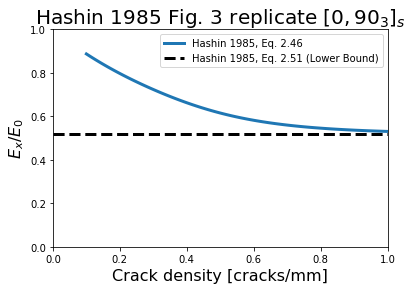

In [4]:
# Plot figure
plt.figure()
ax=plt.gca()
plt.plot(c,ExNorm,linewidth=3,label='Hashin 1985, Eq. 2.46')
plt.ylabel('$E_x$/$E_0$', fontsize=16)
plt.xlabel('Crack density [cracks/mm]', fontsize=16)
plt.title('Hashin 1985 Fig. 3 replicate $[0,90_3]_s$', fontsize=20)
ax.set_ylim([0,1])
ax.set_xlim([0,cMax])
plt.plot((0, cMax), (ElimNorm, ElimNorm), 'k--',linewidth=3,label='Hashin 1985, Eq. 2.51 (Lower Bound)')
plt.legend(numpoints=1)